In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import esm4ppe
import numpy as np
import re
import xarray as xr
from dask.diagnostics import ProgressBar

In [13]:
eo = esm4ppe.esm4ppeObj('intpp','monthly').add_control(triggeropen=True)
eo

Opening static... static opened.
Control present in zarr store... opening... control opened.


In [14]:
eo = eo.regionalmean(masksname='LME',saveregionalmean=True,verbose=True)

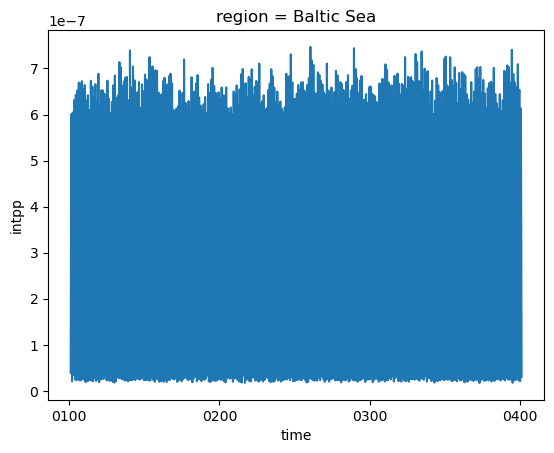

In [15]:
eo.control.sel(region='Baltic Sea')['intpp'].plot()

In [36]:
def _load_LMEmask():
    path = '/work/gam/LargeMarineEcos/derived_masks/LME66.ESM4.nc'
    return xr.open_dataset(path)

def _generate_basinmask(static,geolon='geolon',geolat='geolat'):
    ''' Use static basin and geolon and geolat to generate mask booleans for a range of ocean regions.'''
    masks = xr.Dataset()
    flag_values = static['basin'].attrs['flag_values'].split(' ')
    flag_meanings = static['basin'].attrs['flag_meanings'].split(' ')
    latbounds = np.array([-60, -45, -20, 20, 45, 60])
    latnames = ['SoP', 'SoSubP', 'SoSubT','T','NoSubT','NoSubP','NoP']
    lonbounds = np.array([-214,-68,20])
    lonnames = ['pacific','atlantic','indian']
    lonbounds_arctic = np.array([-220 , -50])
    lonnames_arctic = ['pacific','atlantic']

    for b in flag_values:
        bi = int(b)
        name = flag_meanings[bi].split('_')[0]
        masks[name]=(static['basin']==bi)
        # Reverse boolean for land mask
        if name=='global':
            masks[name]=~masks[name]
        # Split up by latitudes
        for li,latname in enumerate(latnames):
            if (li == 0):
                newcond = (static[geolat] <= latbounds[li])
            elif (li == len(latnames)-1):
                newcond = (static[geolat] > latbounds[li-1])
            else:
                newcond = (static[geolat] > latbounds[li-1])  & (static[geolat] <= latbounds[li])
            masks[name+'_'+latname] = (masks[name]) & (newcond)
        # Split up Southern Ocean by longitude
        if name=='southern':
            for li,lonname in enumerate(lonnames):
                if li==len(lonnames)-1: # Wrap
                    newcond = (static[geolon]>lonbounds[li]) | (static[geolon]<lonbounds[0])
                else:
                    newcond = (static[geolon]>lonbounds[li]) & (static[geolon]<=lonbounds[li+1])
                masks[name+'_'+lonname] = (masks[name]) & (newcond) 
        # Split up Arctic Ocean by longitude
        if name=='arctic':
            for li,lonname in enumerate(lonnames_arctic):
                if li==len(lonnames_arctic)-1: # Wrap
                    newcond = (static[geolon]>lonbounds_arctic[li]) | (static[geolon]<lonbounds_arctic[0])
                else:
                    newcond = (static[geolon]>lonbounds_arctic[li]) & (static[geolon]<=lonbounds_arctic[li+1])
                masks[name+'_'+lonname] = (masks[name]) & (newcond)

    # Now build global basin masks
    for name in ['pacific','atlantic','indian']:
        masks[name+'_global']=masks[name].copy()
        r = re.compile(".*"+name)
        bs = list(filter(r.match, list(masks.keys())))
        for b in bs:
            masks[name+'_global']+=masks[b].copy()
            
    # Now remove any empty masks
    masksnow = masks.copy()
    for name, mask in masks.items():
        if ~mask.any():
            masksnow.drop(name)
            
    return masksnow

def get_masks(name,static):
    if name=='LME':
        return _load_LMEmask()
    if name=='basin':
        return _generate_basinmask(static)

In [37]:
def get_dimensionslesstime(da):
    return [dim for dim in list(da.dims) if dim!='time']

def _calc_regionalmean(da,mask,weights):
    dims = get_dimensionslesstime(da)
    return da.where(mask,drop=True).weighted(weights.fillna(0)).mean(dims)

def calc_regionalmean(da,masks,weights,verbose=False):
    ''' Calculate regional means for [da] based on [masks].
    Return DataArray with "region" dimension corresponding to masknames.'''
    coords_out = dict(da.coords)
    dims = get_dimensionslesstime(da)
    coords_out.pop(dims[0])
    coords_out.pop(dims[1])
    dims_orig = list(coords_out.keys())
    coords_out['region']=list(masks.keys())
    da_out = xr.DataArray(dims=coords_out.keys(),coords=coords_out,name=da.name)
        
    for name,mask in masks.items():
        if verbose:
            print('region: '+name)
            with ProgressBar():
                da_out.loc[{'region':name}] = _calc_regionalmean(da,mask,weights).transpose(*dims_orig)
        else:
            da_out.loc[{'region':name}] = _calc_regionalmean(da,mask,weights).transpose(*dims_orig)
    return da_out

In [38]:
masks = get_masks('LME',eo.static)

In [39]:
rm = calc_regionalmean(eo.control,masks,eo.static['areacello'],verbose=True)

region: Baltic Sea
[########################################] | 100% Completed | 4.18 ss
region: Sea of Okhotsk
[########################################] | 100% Completed | 3.81 sms
region: North Sea
[########################################] | 100% Completed | 3.70 sms
region: Gulf of Alaska
[########################################] | 100% Completed | 3.75 sms
region: Labrador - Newfoundland
[########################################] | 100% Completed | 4.03 sms
region: Celtic-Biscay Shelf
[########################################] | 100% Completed | 3.94 sms
region: Sea of Japan
[########################################] | 100% Completed | 3.61 sms
region: Oyashio Current
[########################################] | 100% Completed | 3.70 sms
region: Scotian Shelf
[########################################] | 100% Completed | 3.98 sms
region: California Current
[########################################] | 100% Completed | 3.76 sms
region: Black Sea
[###################################